In [12]:
import numpy as np
from datetime import datetime
import pandas as pd
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
from torch.utils.data.dataset import Dataset
from sklearn.metrics import balanced_accuracy_score

In [13]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision
from torchvision import datasets, models, transforms
from torch.nn.utils import weight_norm
import matplotlib.pyplot as plt
import time
import os,sys
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
torch.cuda.is_available()

PyTorch Version:  1.5.1
Torchvision Version:  0.6.1


True

In [14]:
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        weight_norm(nn.Conv3d(in_channels, out_channels, 3, padding=1)),
        nn.ReLU(inplace=True),
#         weight_norm(nn.Conv3d(out_channels, out_channels, 3, padding=1)),
#         nn.ReLU(inplace=True)
    )   


class UNet(nn.Module):

    def __init__(self, n_class, in_channels,dropout=0.2):
        super().__init__()
                
        self.dconv_down1 = double_conv(in_channels, 16)
        self.dconv_down2 = double_conv(16, 32)
        self.dconv_down3 = double_conv(32, 64)
        self.dconv_down4 = double_conv(64, 128)
        self.dconv_down5 = double_conv(128, 256)

        self.maxpool = nn.MaxPool3d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='trilinear', align_corners=True)        
        
        self.dconv_up4 = double_conv(128 + 256, 128)
        self.dconv_up3 = double_conv(64 + 128, 64)
        self.dconv_up2 = double_conv(32 + 64, 32)
        self.dconv_up1 = double_conv(16 + 32, 16)
        
        self.conv_last = nn.Conv3d(16, in_channels, 1)
        self.fc1 = nn.Linear(2048 ,1024)
        self.bn_fc1 = nn.BatchNorm1d(1024)
        self.dropout1 = nn.Dropout(dropout)
        self.out = nn.Linear(1024, n_class)
        self.relu = nn.ReLU()
#         self.signmoid = nn.Sigmoid()
#         self.init_weights()
        
#     def init_weights(self):
#         self.dconv_down1.weight.data.normal_(0, 0.01)
#         self.dconv_down2.weight.data.normal_(0, 0.01)
#         self.dconv_down3.weight.data.normal_(0, 0.01)
#         self.dconv_down4.weight.data.normal_(0, 0.01)
#         self.dconv_up3.weight.data.normal_(0, 0.01)
#         self.dconv_up2.weight.data.normal_(0, 0.01)
#         self.dconv_up1.weight.data.normal_(0, 0.01)
#         self.conv_last.weight.data.normal_(0, 0.01)
        
    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   
        
        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4) 
        
        x = self.dconv_down5(x) 
        
        #Classifier
        x1 = self.maxpool(x)
        flatten = x1.view(x1.size(0),-1)
#         print('fc:',flatten.size())
        y = self.fc1(flatten)
        y = self.bn_fc1(y)
        y = self.relu(y)
        y = self.dropout1(y)

        y = self.out(y)
#         print('out:',x.size())
        prediction = nn.functional.log_softmax(y,dim=1)
    
        x = self.upsample(x)
        x = torch.cat([x, conv4], dim=1)
        x = self.dconv_up4(x)
        
        
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)
        
        x = self.dconv_up3(x)
        x = self.upsample(x)
        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   
        
        x = self.dconv_up1(x)
        
        x = self.conv_last(x)
        out = self.relu(x)
        
        return out,prediction

In [15]:
def init_weights(m):
# print(m)
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        m.weight.data.normal_(0, 0.01)
# print(m.weight)

# net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
# net.apply(init_weights)

In [16]:
# from torchsummary import summary

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = UNet(3,1)
# model.apply (init_weights)
# model = model.to(device)
# # model
# summary(model, input_size=(1, 80, 80, 80))

In [17]:
from collections import defaultdict
import torch.nn.functional as F

In [18]:
def calc_loss(out, prediction, target, original, metrics, MSE_weight=0.5):
    CE = F.cross_entropy(prediction, target)
#     BCE = F.binary_cross_entropy_with_logits(prediction, target)
#     out = torch.sigmoid(out)
    MSE = F.mse_loss(out*65535, original*65535)
    
    loss = MSE * MSE_weight + CE * (1 - MSE_weight)
#     loss = MSE * MSE_weight + CE
    
    metrics['CE'] += CE.data.cpu().numpy() * target.size(0)
    metrics['MSE'] += MSE.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))   

In [19]:
def train_model(model, dataloaders, optimizer1, optimizer2, scheduler1, scheduler2, num_epochs=25):
    start = datetime.now()
    val_acc_history = []
    train_acc_history = []
    val_Bacc_history = []
    train_Bacc_history = []
    val_loss_history = []
    train_loss_history = []
    val_MSEloss_history = []
    lr_history = []
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            LabelList = torch.tensor([1]).to(device)
            PredList = torch.tensor([1]).to(device)
            if phase == 'train':
                if epoch < 5:
                    for param_group in optimizer1.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                else:
                    for param_group in optimizer2.param_groups:
                        print("LR", param_group['lr'])
                        lr_history.append(param_group['lr'])
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
#             running_loss = 0.0
            running_corrects = 0
            confusion_matrix = torch.zeros(3, 3)
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                if epoch < 5:
                    optimizer1.zero_grad()
                else:
                    optimizer2.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs,predictions = model(inputs)
                    loss = calc_loss(outputs, predictions,labels,inputs, metrics,MSE_weight = 1e-7)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        if epoch < 5:
                            optimizer1.step()
                        else:
                            optimizer2.step()
                _, preds = torch.max(predictions, 1)
                # statistics
                epoch_samples += inputs.size(0)
                # statistics
                LabelList = torch.cat([LabelList,labels.view(-1)],dim=0)
                PredList = torch.cat([PredList, preds.view(-1)],dim=0)
#                 print(labels.shape)
#                 print(type(labels))
#                 print(len(LabelList))
#                 print(len(PredList))
#                 for t, p in zip(labels.view(-1), preds.view(-1)):
#                     confusion_matrix[t.long(), p.long()] += 1
                  
                running_corrects += torch.sum(preds == labels.data)
            
            
#             confusionMat = np.asarray(confusion_matrix)
#             sumconfusion = np.sum(confusionMat,axis = 1).T

#             summat = np.tile(sumconfusion,(3,1)).T
            # print(test)
#             percentconfusion = np.divide(confusionMat,summat)
#             epoch_acc_balanced = np.sum(np.diagonal(percentconfusion))/3
            epoch_acc_balanced = balanced_accuracy_score(LabelList[1:].cpu(), PredList[1:].cpu())
            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_acc = running_corrects.double() / epoch_samples
            print('{} Acc: {:.4f}'.format(phase, epoch_acc))
            print('{} Bal. Acc: {:.4f}'.format(phase, epoch_acc_balanced))
#             print('{} Bal. Acc from List: {:.4f}'.format(phase, balanced_accuracy_score(LabelList[1:].cpu(), PredList[1:].cpu())))
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                print("saving best model")
                best_acc = epoch_acc
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_Bacc_history.append(epoch_acc_balanced)
                val_loss_history.append(epoch_loss)
                val_MSEloss_history.append(metrics['MSE']/epoch_samples)
                if epoch < 5:
                    scheduler1.step(epoch_loss)
                elif epoch > num_epochs * (2/3):
                    scheduler2.step(epoch_loss)

            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_Bacc_history.append(epoch_acc_balanced)
                train_loss_history.append(epoch_loss)
#             if epoch_acc == 1:
#                 break
        
        if epoch > 1 and val_MSEloss_history[-1] > 7e7 :
                break
        print("Total time: %s" %(datetime.now() - start))
        time_elapsed = time.time() - since
        print('Epoch time: {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))
    print('Best val acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model,train_acc_history,train_loss_history,val_acc_history,val_loss_history,lr_history,train_Bacc_history,val_Bacc_history

In [20]:
# Datadir = "E:\\WBC_Type_Classification_v4\\Dataset\\3DImagesDeconv-aug-fortrain\\Fold-1"
# Datadir = "E:\\WBC_Type_Classification_v4\\Dataset\\3DImages-aug"
DatadirTrain = "F:\\WBC_Type_Classification_v4\\Dataset\\3DImagesKFold-aug"
DatadirVal = "F:\\WBC_Type_Classification_v4\\Dataset\\3DImagesKFold-aug"

In [21]:
# import os
# import os.path

# for dirpath, dirnames, filenames in os.walk("."):
#     for filename in [f for f in filenames if f.endswith(".log")]:
#         print os.path.join(dirpath, filename)
FoldName = ["Fold-1","Fold-2","Fold-3","Fold-4","Fold-5"]
tempName =FoldName
ValFold = tempName.pop(1)
# FoldName = tempName
print(FoldName)
print(ValFold)
for name in FoldName:
    print(name)

['Fold-1', 'Fold-3', 'Fold-4', 'Fold-5']
Fold-2
Fold-1
Fold-3
Fold-4
Fold-5


In [22]:
import os

def datapreparation(DatadirTrain,DatadirVal,Fold):
    trainpath = []
    FoldName = ["Fold-1","Fold-2","Fold-3","Fold-4","Fold-5"]
    ValFold = FoldName.pop(Fold)
    
    fpath = []
    traindir = DatadirTrain + "\\Gra_Y"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Gra train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    fpath = []
    traindir = DatadirTrain + "\\Lym_G"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Lym train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    fpath = []
    traindir = DatadirTrain + "\\Mon_U"
    for name in FoldName:
        trainsubdir = traindir + "\\" + name
        for dirpath, dirnames, filenames in os.walk(trainsubdir):
            for filename in [f for f in filenames if f.endswith(".tif")]:
                tempfpath =os.path.join(dirpath, filename)
                fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Mon train data: %d' %(len(train)))
    for i in train:
        trainpath.append(fpath[i])

    minitrainpath = []
    minivalpath = []
    valpath = []
    
    fpath = []
    traindir = DatadirVal + "\\Gra_Y"+"\\"+ ValFold
    print(traindir)
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Gra Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i])
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Gra mini-train data: %d' %(len(minitrain)))
    print('Gra mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])

    fpath = []
    traindir = DatadirVal + "\\Lym_G"+"\\"+ ValFold
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Lym Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i]) 
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Lym mini-train data: %d' %(len(minitrain)))
    print('Lym mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])

    fpath = []
    traindir = DatadirVal + "\\Mon_U"+"\\"+ ValFold
    for dirpath, dirnames, filenames in os.walk(traindir):
        for filename in [f for f in filenames if f.endswith(".tif")]:
            tempfpath =os.path.join(dirpath, filename)
            fpath.append(tempfpath)
    train = list(range(1,len(fpath)))
    print('Mon Val data: %d' %(len(train)))
    for i in train:
        valpath.append(fpath[i])
    minitrain, minival = train_test_split(train, test_size=0.2, random_state=3)
    print('Mon mini-train data: %d' %(len(minitrain)))
    print('Mon mini-val data: %d' %(len(minival)))
    for i in minitrain:
        minitrainpath.append(fpath[i])
    for i in minival:
        minivalpath.append(fpath[i])
    return trainpath,valpath,minitrainpath,minivalpath

In [23]:
Fold = 0
trainpath,testpath,_,_= datapreparation(DatadirTrain,DatadirVal,Fold)

Gra train data: 10856
Lym train data: 9791
Mon train data: 9113
F:\WBC_Type_Classification_v4\Dataset\3DImagesKFold-aug\Gra_Y\Fold-1
Gra Val data: 2714
Gra mini-train data: 2171
Gra mini-val data: 543
Lym Val data: 2451
Lym mini-train data: 1960
Lym mini-val data: 491
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608


In [24]:
print('train data vol.: ',len(trainpath))
print('test data vol.: ',len(testpath))

train data vol.:  29760
test data vol.:  8202


In [25]:
from skimage import io
import skimage.transform
import scipy
class MyDataset(Dataset):
    def __init__(self, mat_paths, transforms=None):
        self.paths = mat_paths
        self.transforms = transforms
        
    def __getitem__(self, index):
        # Load .mat
#         data = loadmat(self.paths[index])
        data = io.imread(self.paths[index])
#         reshape = skimage.transform.resize(data,(224,224,40))
#         x = torch.from_numpy(reshape.astype(np.float32))
#         x = torch.from_numpy(data.astype(np.float32)/65535)
        x = torch.from_numpy(data.astype(np.float32)/65535)
        x = x.unsqueeze(dim = 0)
#         x = x.type(torch.HalfTensor)
#         x = np.transpose(x,(2,0,1))
#         x = np.transpose(np.array(data['Data']),(2,0,1))
        if 'Gra' in self.paths[index]:
            label = int(0)
        elif 'Lym' in self.paths[index]:
            label = int(1)
        elif 'Mon' in self.paths[index]:
            label = int(2)
        if self.transforms:
            x= self.transforms(x)
        return x,label
    
    def __len__(self):
        return len(self.paths)

In [26]:
#actual training
image_datasets = {}
mini_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(testpath)
# mini_datasets['train'] = MyDataset(minitrainpath)
# mini_datasets['val'] = MyDataset(minivalpath)
# model testing
# image_datasets['train'] = MyDataset(valpath)
# image_datasets['val'] = MyDataset(testpath)
# test_datasets['val'] = MyDataset(testpath)
print('training data volume: ', image_datasets['train'].__len__())
print('validation data volume: ', image_datasets['val'].__len__())

# print('mini-training data volume: ', mini_datasets['train'].__len__())
# print('mini-validation data volume: ', mini_datasets['val'].__len__())

CellName = ['Granulocyte','Lymphocyte','Monocyte']
image_datasets['train'].__getitem__(0)[0].shape
[ImgTensor,ImgLabel] = image_datasets['train'].__getitem__(0)
print('Granulocytes Label: ',CellName[ImgLabel])
print('image tensor shape: ', ImgTensor.shape)
print('image tensor dtype: ', ImgTensor.dtype)
image_datasets['train'].__getitem__(0)[0]

#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
image = np.squeeze(ImgTensor.numpy())
print('image shape: ', image.shape)

training data volume:  29760
validation data volume:  8202
Granulocytes Label:  Granulocyte
image tensor shape:  torch.Size([1, 80, 80, 80])
image tensor dtype:  torch.float32
image shape:  (80, 80, 80)


C:\Users\tonyt\.conda\envs\pytorch-gpu\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  app.launch_new_instance()


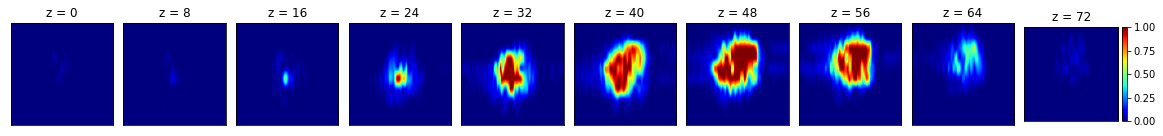

In [27]:
#Visualize image stacks
from mpl_toolkits.axes_grid1 import make_axes_locatable
# image = np.transpose(ImgTensor.numpy(), (1,2,0))

def DisplayImage(img,MinLim,MaxLim): 
    plt.figure(figsize=(20,20))
    for depth in range (0,80,8):
        
        plt.subplot(1,10,depth/8+1)
        fig4 = plt.imshow(img[:,:,depth],vmin=MinLim, vmax=MaxLim, cmap ='jet')
        fig4.axes.get_xaxis().set_visible(False)
        fig4.axes.get_yaxis().set_visible(False)
        # plt.colorbar()
        plt.title('z = '+ str(depth))
        if depth==72:
            plt.subplot(1,10,depth/8+1)
            plt.title('z = '+ str(depth))
            ax = plt.gca()
            fig4 = plt.imshow(img[:,:,depth],vmin=MinLim, vmax=MaxLim, cmap ='jet')
            fig4.axes.get_xaxis().set_visible(False)
            fig4.axes.get_yaxis().set_visible(False)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(fig4, cax=cax)
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
DisplayImage(image,image.min(),image.max())

In [28]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 32
# Create training and validation datasets
# image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}
# dataloaders_dict = {}
# dataloaders_dict ['train'] = torch.utils.data.DataLoader(image_datasets['train'],batch_size=batch_size, num_workers=0, sampler=weighted_sampler)
# dataloaders_dict ['val'] = torch.utils.data.DataLoader(image_datasets['val'],batch_size=batch_size, shuffle=True, num_workers=0)
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


Fold- 1 : Initializing Datasets and Dataloaders...
Gra train data: 10857
Lym train data: 9795
Mon train data: 9113
F:\WBC_Type_Classification_v4\Dataset\3DImagesKFold-aug\Gra_Y\Fold-2
Gra Val data: 2713
Gra mini-train data: 2170
Gra mini-val data: 543
Lym Val data: 2447
Lym mini-train data: 1957
Lym mini-val data: 490
Mon Val data: 3037
Mon mini-train data: 2429
Mon mini-val data: 608
Epoch 0/69
----------
LR 1e-05
train: CE: 0.470101, MSE: 5560072.279233, loss: 1.026108
train Acc: 0.8181
train Bal. Acc: 0.8111
val: CE: 0.416651, MSE: 421554.534841, loss: 0.458807
val Acc: 0.8388
val Bal. Acc: 0.8318
saving best model
Total time: 0:21:24.351742
Epoch time: 21m 24s
Epoch 1/69
----------
LR 1e-05
train: CE: 0.339023, MSE: 257852.247194, loss: 0.364808
train Acc: 0.8738
train Bal. Acc: 0.8697
val: CE: 0.400576, MSE: 159278.148364, loss: 0.416504
val Acc: 0.8436
val Bal. Acc: 0.8490
saving best model
Total time: 0:42:44.108886
Epoch time: 21m 20s
Epoch 2/69
----------
LR 1e-05
train: CE: 0

train: CE: 0.032207, MSE: 4551.730428, loss: 0.032662
train Acc: 0.9911
train Bal. Acc: 0.9907
val: CE: 0.337985, MSE: 4167.233079, loss: 0.338401
val Acc: 0.9085
val Bal. Acc: 0.9070
Total time: 10:40:19.838084
Epoch time: 21m 22s
Epoch 30/69
----------
LR 1e-05
train: CE: 0.033206, MSE: 4316.205747, loss: 0.033638
train Acc: 0.9898
train Bal. Acc: 0.9894
val: CE: 0.338112, MSE: 3942.297168, loss: 0.338507
val Acc: 0.9083
val Bal. Acc: 0.9072
Total time: 11:01:41.622909
Epoch time: 21m 22s
Epoch 31/69
----------
LR 1e-05
train: CE: 0.030565, MSE: 4063.028572, loss: 0.030971
train Acc: 0.9909
train Bal. Acc: 0.9906
val: CE: 0.343260, MSE: 3839.077172, loss: 0.343644
val Acc: 0.9098
val Bal. Acc: 0.9101
Total time: 11:23:03.710199
Epoch time: 21m 22s
Epoch 32/69
----------
LR 1e-05
train: CE: 0.022822, MSE: 3845.475972, loss: 0.023206
train Acc: 0.9943
train Bal. Acc: 0.9941
val: CE: 0.333813, MSE: 3505.634752, loss: 0.334164
val Acc: 0.9113
val Bal. Acc: 0.9096
Total time: 11:44:25.996

train: CE: 0.003870, MSE: 1497.270717, loss: 0.004019
train Acc: 0.9994
train Bal. Acc: 0.9994
val: CE: 0.443879, MSE: 1465.267407, loss: 0.444026
val Acc: 0.9119
val Bal. Acc: 0.9109
Total time: 21:42:21.748995
Epoch time: 21m 22s
Epoch 61/69
----------
LR 5e-06
train: CE: 0.003573, MSE: 1473.314751, loss: 0.003720
train Acc: 0.9993
train Bal. Acc: 0.9993
val: CE: 0.521704, MSE: 1432.323266, loss: 0.521848
val Acc: 0.9035
val Bal. Acc: 0.9080
Total time: 22:03:43.995399
Epoch time: 21m 22s
Epoch 62/69
----------
LR 5e-06
train: CE: 0.003541, MSE: 1444.891537, loss: 0.003685
train Acc: 0.9992
train Bal. Acc: 0.9991
val: CE: 0.452824, MSE: 1393.530655, loss: 0.452964
val Acc: 0.9130
val Bal. Acc: 0.9130
Total time: 22:25:03.737407
Epoch time: 21m 20s
Epoch 63/69
----------
LR 5e-06
train: CE: 0.003255, MSE: 1411.403416, loss: 0.003396
train Acc: 0.9993
train Bal. Acc: 0.9992
val: CE: 0.426760, MSE: 1513.614383, loss: 0.426911
val Acc: 0.9155
val Bal. Acc: 0.9153
Total time: 22:46:21.971

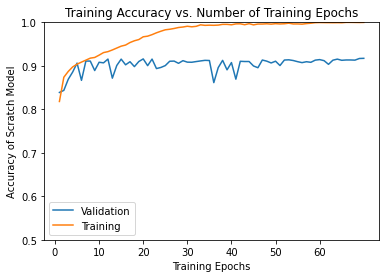

70


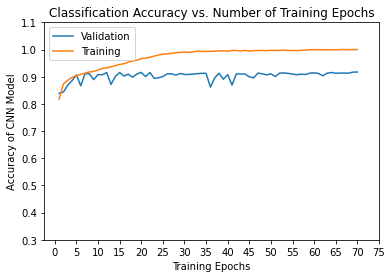

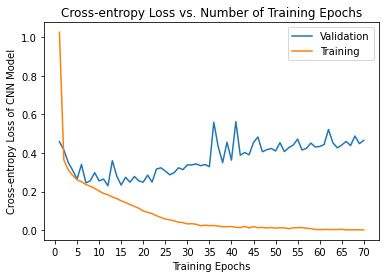

tensor([[2652.,   21.,   40.],
        [  45., 2231.,  171.],
        [ 102.,  299., 2636.]])
[2799. 2551. 2847.]
[[0.97751564 0.00774051 0.01474383]
 [0.01838987 0.9117286  0.06988148]
 [0.03358578 0.09845242 0.8679618 ]]





C:\Users\tonyt\.conda\envs\pytorch-gpu\lib\site-packages\torch\serialization.py:402: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [29]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import copy

for runs in range (1,2):
    print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
    #Kfold
    Fold = runs
    trainpath,testpath,minitrainpath,minitestpath= datapreparation(DatadirTrain,DatadirVal,Fold)
    image_datasets = {}
    image_datasets['train'] = MyDataset(trainpath)
    image_datasets['val'] = MyDataset(testpath)

    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=0) for x in ['train', 'val']}

    # Detect if we have a GPU available
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    num_class = 3
    in_channel = 1
    num_epochs = 70
    loss_hist_train = []
    while (len(loss_hist_train)<num_epochs/2):
        model = UNet(num_class, in_channel)
        model.apply(init_weights)
#         model.half() 
        model = model.to(device)

        # freeze backbone layers
        # Comment out to finetune further
        # for l in model.base_layers:
        #     for param in l.parameters():
        #         param.requires_grad = False

        optimizer_ft1 = optim.Adam(model.parameters(), lr=1e-5,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        optimizer_ft2 = optim.Adam(model.parameters(), lr=1e-5,betas = (0.9, 0.999),eps=1e-08,weight_decay=0)
        # optimizer_ft1 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # optimizer_ft2 = optim.Adadelta(model.parameters(), lr=1e-3, rho=0.9, eps=1e-06, weight_decay=0)
        # exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1) 
        exp_lr_scheduler1 = lr_scheduler.ReduceLROnPlateau(optimizer_ft1, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)
        exp_lr_scheduler2 = lr_scheduler.ReduceLROnPlateau(optimizer_ft2, mode='min', factor=0.5, patience=5, verbose=True, threshold=0.0001, threshold_mode='rel', cooldown=1, min_lr=1e-7, eps=1e-08)       
        model, scratch_hist_train,loss_hist_train,scratch_hist_val, loss_hist_val,lr_hist,train_Bacc_hist,val_Bacc_hist = train_model(model, dataloaders_dict,optimizer_ft1, optimizer_ft2, exp_lr_scheduler1,exp_lr_scheduler2, num_epochs)
        if len(loss_hist_train)<num_epochs:
            print('model diverges, reinitializing training....\n')
            print("Fold-",str(runs),": Initializing Datasets and Dataloaders...")
        
    # num_epochs=15
    fname1 = "training_acc_"+str(runs)+".csv"
    np.savetxt(fname1,scratch_hist_train , delimiter=",")
    fname2 = "validation_acc_"+str(runs)+".csv"
    np.savetxt(fname2,scratch_hist_val , delimiter=",")
    fname13 = "training_Bacc_"+str(runs)+".csv"
    np.savetxt(fname13,train_Bacc_hist, delimiter=",")
    fname23 = "validation_Bacc_"+str(runs)+".csv"
    np.savetxt(fname23,val_Bacc_hist, delimiter=",")
    fname20 = "training_loss_"+str(runs)+".csv"
    np.savetxt(fname20,loss_hist_train , delimiter=",")
    fname21 = "validation_loss_"+str(runs)+".csv"
    np.savetxt(fname21,loss_hist_val , delimiter=",")
    fname22 = "learning_rate_"+str(runs)+".csv"
    np.savetxt(fname22,lr_hist , delimiter=",")
    
    shist = []
    shist1 = []

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Training Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of Scratch Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.5,1.))
    plt.xticks(np.arange(0, num_epochs, 10.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'.png'
    plt.savefig(fname3)
    plt.show()

    shist = [h.cpu().numpy() for h in scratch_hist_val]
    shist1 = [h.cpu().numpy() for h in scratch_hist_train]
    print(len(shist))
    plt.title("Classification Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy of CNN Model")
    plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
    plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
    plt.ylim((0.3,1.1))
    plt.xticks(np.arange(0, len(shist)+10, 5.0))
    plt.legend()
    fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
    plt.savefig(fname3)
    plt.show()

    train_loss = [h for h in loss_hist_train]
    val_loss = [h for h in loss_hist_val]
    plt.title("Cross-entropy Loss vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Cross-entropy Loss of CNN Model")
    plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
    plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
    #     plt.ylim((0.5,1.05))
    plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
    plt.legend()
    fname31 = 'loss_curve_'+str(runs)+'.png'
    plt.savefig(fname31)
    plt.show()

    confusion_matrix = torch.zeros(num_classes, num_classes)
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
            inputs = inputs.type(torch.FloatTensor)
            inputs = inputs.to(device)
            classes = classes.to(device)
            _, outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    print(confusion_matrix)
    confusionMat = np.asarray(confusion_matrix)
    sumconfusion = np.sum(confusionMat,axis = 0)
    print(sumconfusion)

    import scipy
    sumconfusion = np.sum(confusionMat,axis = 1).T
    # print(np.tile(sumconfusion,(4,1)))
    summat = np.tile(sumconfusion,(3,1)).T
    # print(test)
    percentconfusion = np.divide(confusionMat,summat)
    print(percentconfusion)
    fname4 = "confusion_Mat_UNet_confusionMat_"+str(runs)+".csv"
    np.savetxt(fname4,confusionMat , delimiter=",")
    fname5 = "confusion_Mat_UNet_confusionPer_"+str(runs)+".csv"
    np.savetxt(fname5,percentconfusion , delimiter=",")
    fname6 = 'celltypemodel-unet_3D3D_Run_'+str(runs)+'.pth.tar'

    torch.save(model,fname6)
    print('\n\n')

In [ ]:
runs = 1
# num_epochs=15
fname1 = "training_acc_"+str(runs)+".csv"
np.savetxt(fname1,scratch_hist_train , delimiter=",")
fname2 = "validation_acc_"+str(runs)+".csv"
np.savetxt(fname2,scratch_hist_val , delimiter=",")
fname11 = "training_loss_"+str(runs)+".csv"
np.savetxt(fname11,loss_hist_train , delimiter=",")
fname21 = "validation_loss_"+str(runs)+".csv"
np.savetxt(fname21,loss_hist_val , delimiter=",")

shist = []
shist1 = []

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Training Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of Scratch Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.7,1.1))
plt.xticks(np.arange(0, num_epochs, 10.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'.png'
plt.savefig(fname3)
plt.show()

shist = [h.cpu().numpy() for h in scratch_hist_val]
shist1 = [h.cpu().numpy() for h in scratch_hist_train]
print(len(shist))
plt.title("Classification Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy of CNN Model")
plt.plot(range(1,len(shist)+1),shist[0:len(shist)],label="Validation")
plt.plot(range(1,len(shist)+1),shist1[0:len(shist)],label="Training")
plt.ylim((0.5,1.1))
plt.xticks(np.arange(0, len(shist)+10, 5.0))
plt.legend()
fname3 = 'training_curve_'+str(runs)+'backup'+'.png'
plt.savefig(fname3)
plt.show()

train_loss = [h for h in loss_hist_train]
val_loss = [h for h in loss_hist_val]
plt.title("Total Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Total Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname31 = 'loss_curve_'+str(runs)+'.png'
plt.savefig(fname31)
plt.show()

train_loss = [h for h in CE_train]
val_loss = [h for h in CE_val]
plt.title("Cross-entropy Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Cross-entropy Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname32 = 'CE-loss_curve_'+str(runs)+'.png'
plt.savefig(fname32)
plt.show()

train_loss = [h for h in MSE_train]
val_loss = [h for h in MSE_val]
plt.title("MSE Loss vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("MSE Loss of CNN Model")
plt.plot(range(1,len(val_loss)+1),val_loss[0:len(val_loss)],label="Validation")
plt.plot(range(1,len(train_loss)+1),train_loss[0:len(train_loss)],label="Training")
#     plt.ylim((0.5,1.05))
plt.xticks(np.arange(0, len(val_loss)+5, 5.0))
plt.legend()
fname33 = 'MSE-loss_curve_'+str(runs)+'.png'
plt.savefig(fname33)
plt.show()

confusion_matrix = torch.zeros(num_classes, num_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        _, outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
confusionMat = np.asarray(confusion_matrix)
sumconfusion = np.sum(confusionMat,axis = 0)
print(sumconfusion)

import scipy
sumconfusion = np.sum(confusionMat,axis = 1).T
# print(np.tile(sumconfusion,(4,1)))
summat = np.tile(sumconfusion,(3,1)).T
# print(test)
percentconfusion = np.divide(confusionMat,summat)
print(percentconfusion)
fname4 = "confusion_Mat_UNet_confusionMat_"+str(runs)+".csv"
np.savetxt(fname4,confusionMat , delimiter=",")
fname5 = "confusion_Mat_UNet_confusionPer_"+str(runs)+".csv"
np.savetxt(fname5,percentconfusion , delimiter=",")
fname6 = 'celltypemodel-unet_80rech_Run_'+str(runs)+'.pth.tar'

torch.save(model,fname6)

In [ ]:
import seaborn as sns
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.1%}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.tile(np.sum(cf,axis = 0),(3,))]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))
#         accuracy  = np.trace(cf) / 3
        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nBalanced Accuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [ ]:
categories = CellName
make_confusion_matrix(percentconfusion, 
                      #group_names=labels,
                      categories=categories,
                      percent=False,
                      cbar=False,
                      figsize=(4 ,4),
                      cmap='Greens',title = '3DCNN UNet - 3D Input')

In [ ]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.size(0),-1)

In [ ]:
class maxpool(nn.Module):
    def __init__(self):
        super(maxpool, self).__init__()
        self.maxpool = nn.MaxPool3d(2)
        
    def forward(self, x):
        x = self.maxpool(x)
        return x

In [ ]:
# Initialize the non-pretrained version of the model used for this run
scratch_model = torch.load('celltypemodel-unet_80rech_Run_1.pth.tar')
scratch_model_fc = nn.Sequential(*(list(scratch_model.children())[:1]),maxpool(),*(list(scratch_model.children())[1:2]),maxpool(),*(list(scratch_model.children())[2:3]),maxpool(),*(list(scratch_model.children())[3:4]),maxpool(),*(list(scratch_model.children())[4:5]),maxpool(),Flatten(),*(list(scratch_model.children())[-5:-4]))
# scratch_model_fc = nn.Sequential(*list(scratch_model.children())[:-3])
scratch_model_fc = scratch_model_fc.to(device)
scratch_model_fc.eval()

In [ ]:
# list(scratch_model.children())

In [ ]:
#testing
image_datasets = {}
test_datasets ={}
image_datasets['train'] = MyDataset(trainpath)
image_datasets['val'] = MyDataset(valpath)
image_datasets['val'].__getitem__(0)[0].shape

In [ ]:
print("Initializing Datasets and Dataloaders...")
# Number of classes in the dataset
num_classes = 3

# Batch size for training (change depending on how much memory you have)
batch_size = 64
# Create training and test dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=False, num_workers=0) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders_dict['val']):
        inputs = inputs.type(torch.FloatTensor)
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = scratch_model_fc(inputs)
        outputs = outputs.cpu().clone().numpy()
        if i == 0:
            outputlist = outputs
            y = classes.cpu().clone().numpy()
        else:
            outputlist = np.append(outputlist,outputs, axis=0)
            y = np.append(y,classes.cpu().clone().numpy(), axis=0)

In [ ]:
print(len(outputlist))
print(outputlist.shape)
print(y.shape)
outputlist = np.squeeze(outputlist)
print(outputlist.shape)

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns
tsne = TSNE(n_components=2, random_state=0,verbose=1, perplexity=40, learning_rate=200,early_exaggeration = 50, n_iter=2000)
X_2d = tsne.fit_transform(outputlist)
CellName = ['HEK-293','HeLa','MCF-7']


In [ ]:
target_ids = range(len(outputlist))
plt.figure()
colors = 'r', 'g', 'b'
for i, c, label in zip(target_ids, colors, CellName):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1],s=3, c=c, label=label,alpha=0.5)
plt.legend()
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('t-SNE plot')
plt.show()

In [ ]:
scratch_model = torch.load('celltypemodel-unet_80rech_Run_1.pth.tar')
scratch_model = scratch_model.to(device)
scratch_model.eval()

In [ ]:
CellName = ['Granulocyte','Lymphocyte','Monocyte']
ImgTensor, Label = image_datasets['val'].__getitem__(2)
image = np.squeeze(ImgTensor.numpy())
print('Ground Truth Cell Type: ', CellName[Label])
DisplayImage(image,image.min(),image.max())

In [ ]:
inputs = torch.unsqueeze(ImgTensor,0).to(device)
[output,prediction] = scratch_model(inputs)
# output = output.squeeze()
output = output.squeeze()
output = output.cpu().clone().detach().numpy()
_, preds = torch.max(prediction, 1)
preds = preds.cpu().clone().detach()

In [ ]:
# print(output/output.max())
print(output.max())
print(output.shape)
print('Predicted Cell Type: ', CellName[preds])
image = np.squeeze(output)
DisplayImage(image,image.min(),image.max())